In [1]:
import os
from keras import layers, models, optimizers
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, smart_resize
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt

print(tf.__version__)

2.4.1


In [2]:
# Check GPU/cuda system compatability
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [3]:
# Dataset
labels = pd.read_csv("train.csv")
labels.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
labels['label']=labels['label'].astype(str)

In [5]:
# Show different diseases
names_of_disease = pd.read_json(r'C:\Users\Arun Kumar\Cassava Leaf Disease classification\train_tfrecords\label_num_to_disease_map.json', typ='series')
names_of_disease

0         Cassava Bacterial Blight (CBB)
1    Cassava Brown Streak Disease (CBSD)
2             Cassava Green Mottle (CGM)
3           Cassava Mosaic Disease (CMD)
4                                Healthy
dtype: object

In [6]:
train_dir = r'C:\Users\Arun Kumar\train_images'
test_dir = r'C:\Users\Arun Kumar\test_images'

In [7]:
import cv2

def load_images(folder, count):
    images = []
    files = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            count -= 1 
            images.append(img)
            files.append(filename)
        if count == 0:
            break
    return images, files

imgs, files = load_images(train_dir, 20)

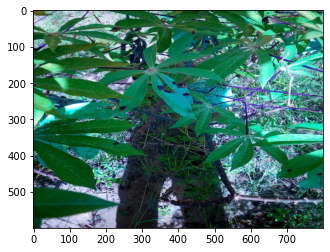

In [8]:
plt.imshow(imgs[0])

In [9]:
labels.iloc[0]

image_id    1000015157.jpg
label                    0
Name: 0, dtype: object

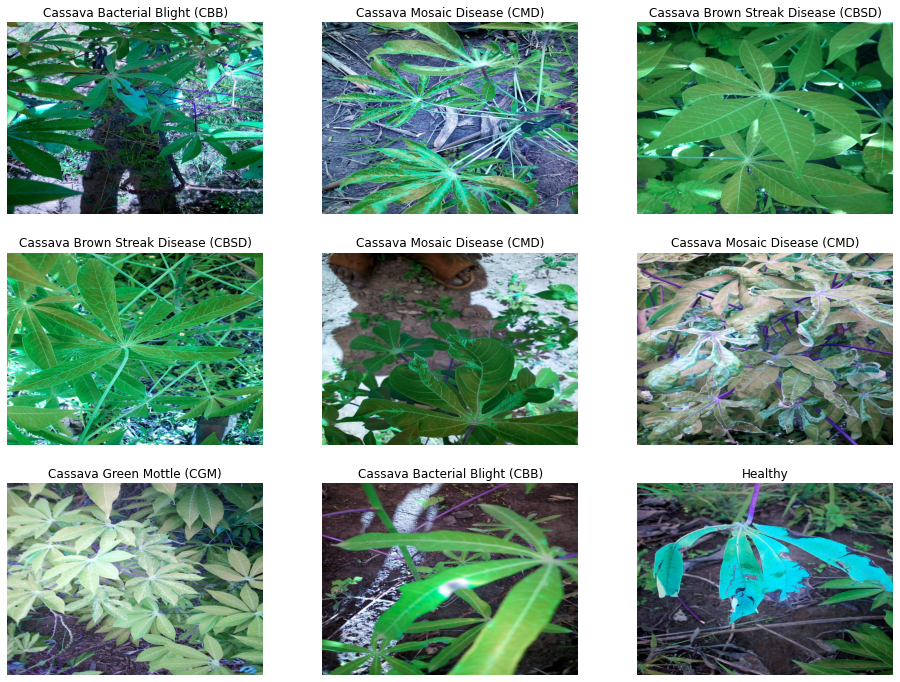

In [10]:
# Showing some pictures

plt.figure(figsize=(16, 12))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = imgs[i]
    array = np.array(image)
    plt.imshow(array)
    plt.axis('off')
    label=labels.iloc[i]['label']
    plt.title(f'{names_of_disease[int(label)]}')
plt.show()

In [11]:
# Data Augmentation
train_datagen = ImageDataGenerator(rescale=1./225,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   validation_split=0.3,
                                   horizontal_flip=True,)


test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_dataframe(dataframe=labels,
                                                    directory=train_dir,
                                                    subset='training',
                                                    x_col="image_id",
                                                    y_col="label",
                                                    shuffle=True,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')

valid_generator = train_datagen.flow_from_dataframe(dataframe=labels,
                                                    directory=train_dir,
                                                    subset='validation',
                                                    x_col="image_id",
                                                    y_col="label",
                                                    shuffle=True,
                                                    target_size=(150,150),
                                                    batch_size=32,
                                                    class_mode='categorical')

Found 14978 validated image filenames belonging to 5 classes.
Found 6419 validated image filenames belonging to 5 classes.


In [13]:
# Prepared Model
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(),
             metrics=['acc'])

In [14]:
callback_list = [
    EarlyStopping(monitor='val_acc',patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1),
    ModelCheckpoint(filepath='{epoch:02d}-{val_acc:.4f}.hdf5', monitor='val_loss',save_best_only=True),
]

In [15]:
history = model.fit(train_generator,steps_per_epoch=30,
                    validation_data=valid_generator,validation_steps=30,
                    callbacks=callback_list, epochs=20)

Epoch 1/20
30/30 [==============================] - 131s 4s/step - loss: 1.4315 - acc: 0.5032 - val_loss: 1.2219 - val_acc: 0.6042
Epoch 2/20
30/30 [==============================] - 117s 4s/step - loss: 1.1630 - acc: 0.6114 - val_loss: 1.1727 - val_acc: 0.6187
Epoch 3/20
30/30 [==============================] - 110s 4s/step - loss: 1.1764 - acc: 0.6197 - val_loss: 1.1670 - val_acc: 0.6250
Epoch 4/20
30/30 [==============================] - 108s 4s/step - loss: 1.2011 - acc: 0.5988 - val_loss: 1.1703 - val_acc: 0.6115
Epoch 5/20
30/30 [==============================] - 109s 4s/step - loss: 1.1385 - acc: 0.6146 - val_loss: 1.1072 - val_acc: 0.6323
Epoch 6/20
30/30 [==============================] - 105s 4s/step - loss: 1.0759 - acc: 0.6429 - val_loss: 1.1314 - val_acc: 0.6104
Epoch 7/20
30/30 [==============================] - 107s 4s/step - loss: 1.1053 - acc: 0.6177 - val_loss: 1.0985 - val_acc: 0.6156


In [16]:
# Accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc)+1)

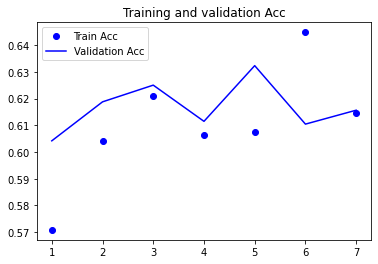

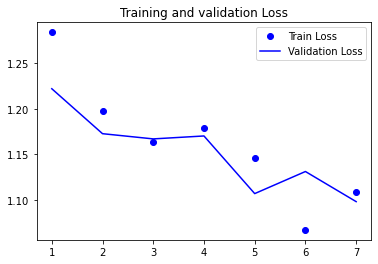

In [17]:
# Plotting
plt.figure()

plt.plot(epochs, acc, 'bo', label='Train Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Train Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend()

plt.show()

In [18]:
img = load_img(r"C:\Users\Arun Kumar\test_images\2216849948.jpg")
img = img_to_array(img)
img = smart_resize(img, (150,150))
img = tf.reshape(img, (-1, 150, 150, 3))

In [19]:
pred = model.predict(img/255.)
pred = np.argmax(pred)
pred

3